In [1]:
import pandas as pd

In [2]:
casp3   = '../casp3'
actives = pd.read_csv(f'{casp3}/actives_final.ism',header=None,delim_whitespace=True,usecols=[2])
decoys  = pd.read_csv(f'{casp3}/decoys_final.ism' ,header=None,delim_whitespace=True,usecols=[1])

actives.columns=['id']
actives['kind']=0

decoys.columns=['id']
decoys['kind']=1

# Someone removed "ZIN" from "ZINC" at decoys_final.ism
decoys['id']='ZIN'+decoys['id']

In [3]:
d = {}

# Read Qvina Scores
d['qvina'] = pd.read_csv('qvina.csv.gz', compression='gzip')
d['qvina'].columns=['id','pose','qvina']

# Read rescores
for SF in ['vina','smina','vinardo']:
    d[SF] = pd.read_csv('rescore_' + SF + '.csv.gz', compression='gzip')
    
# Read RF-ScoreVS_v2 rescore
d['RFScoreVS_v2'] = pd.read_csv('rescore_rfscore.csv.gz', compression='gzip')
d['RFScoreVS_v2'].columns=['pose','id','RFScoreVS_v2']
d['RFScoreVS_v2']['RFScoreVS_v2'] = -d['RFScoreVS_v2']['RFScoreVS_v2']

In [4]:
# Concatenate all into "data"
df   = pd.concat([actives, decoys])
data = pd.merge(df, d['qvina'], on='id')
for v in list(d.values())[1:]:
    data = pd.merge(data, v, on=['id','pose'])

In [5]:
data

,id,kind,pose,qvina,vina,smina,vinardo,RFScoreVS_v2
0,CHEMBL180669,0,1,-4.9,-4.87002,-5.38123,-6.44112,-6.007244
1,CHEMBL180669,0,2,-4.8,-5.02746,-5.64693,-7.07119,-6.046658
2,CHEMBL180669,0,3,-4.7,-4.44643,-4.92047,-5.57386,-5.983515
3,CHEMBL180669,0,4,-4.6,-4.93397,-5.66067,-6.72924,-6.076943
4,CHEMBL180669,0,5,-4.4,-4.65734,-5.55072,-5.69202,-5.985932
...,...,...,...,...,...,...,...,...
45537,ZINC65313129,1,6,-6.0,-6.38491,-6.48218,-5.55877,-5.965331
45538,ZINC65313129,1,7,-6.0,-6.21399,-6.86086,-5.55996,-5.954186
45539,ZINC65313129,1,8,-5.9,-5.97870,-6.53051,-5.25670,-5.961930
45540,ZINC65313129,1,9,-5.6,-5.66919,-5.70003,-5.32602,-5.953678


In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

[Scoring Function]: [AUC]
qvina: 0.669829
vina: 0.678156
smina: 0.654035
vinardo: 0.751204
RFScoreVS_v2: 0.867317


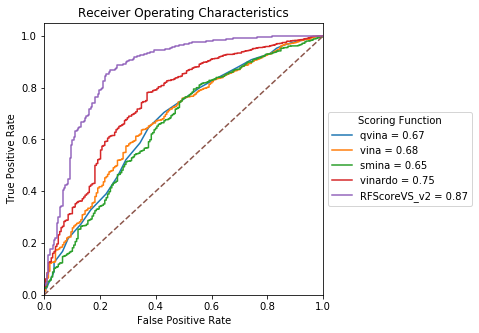

In [7]:
print('[Scoring Function]: [AUC]')
fig, ax = plt.subplots(figsize=(5,5))
for SF in d.keys():
    # 1st top pose according to each scoring function
    df = data.sort_values(SF).groupby('id').head(1)
    fpr, tpr, _ = roc_curve(df['kind'].to_numpy(), df[SF].to_numpy())
    roc_auc = auc(fpr, tpr)
    print(f'{SF}: {roc_auc:>.6f}')
    ax.plot(fpr, tpr, label=f'{SF} = {roc_auc:>.2f}')

# Plot a line
ax.plot([0,1], [0,1], linestyle='--')

# Some legends
ax.set(xlim=[0.0,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel='True Positive Rate', title='Receiver Operating Characteristics')
plt.legend(title='Scoring Function', loc='center left', bbox_to_anchor=(1.0, 0.5))